# Why and When Attention Matters in Reinforcement Learning
> "Using RLlib and AttentionNet to master environments with stateless observations, here, stateless CartPole."

- hide: true
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, ray, rllib, tensorflow, machine learning, reinforcement learning, attention]
- image: images/cartpole.jpg

TODOs:
* Image and short explanation of (self-)attention.
* Proper description of different options


In reinforcement learning (RL), the RL agent typically selects a suitable action based on the last observation.
Since many practical environments are stateful, this state should be taken into account when selecting an action.
As an example, consider the popular [OpenAI Gym CartPole environment](https://gym.openai.com/envs/CartPole-v1/),
where the task is to move a cart left or right in order to balance a pole on the cart as long as possible.

![OpenAI Gym CartPole-v1 Environment](attention/cartpole.gif "OpenAI Gym CartPole-v1 Environment")

Whether the cart should be moved left or right clearly depends on how the pole is currently moving,
i.e., in which direction it is swinging and with which velocity.
In this example, the pole's movement and velocity are an important part of the state,
which should determine the selected action (left or right).

In the following, I show different options how to deal with this state.

* State explicitly observed
* State not observed at all
* Sequence of last observations
* Sequence of last observations + attention

For each case, I use PPO with default hyperparamters.

> Tip: Also check out the [RLlib example using AttentionNet](https://github.com/ray-project/ray/blob/master/rllib/examples/attention_net.py).


## Setup

Install Ray RLlib and TensorFlow (also works with PyTorch) for the RL agent,
Gym and pyglet for the environment, and seaborn for plotting.
I am using Python 3.8 on Windows 10.

In [1]:
#collapse-output
!pip install ray[rllib]==1.8.0
!pip install tensorflow==2.7.0
!pip install seaborn==0.11.2
!pip install gym==0.21.0
!pip install pyglet==1.5.21

Import relevant dependencies and set constants.

In [2]:
import ray
import ray.tune
from ray.rllib.agents import ppo

# adjust num_cpus and num_gpus to your system
# for some reason, num_cpus=2 gets stuck on my system (when trying to train)
ray.init(num_cpus=3, ignore_reinit_error=True)

# stop conditions based on training iterations (each with 4000 train steps)
stop = {"training_iteration": 1}

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


## Explicitly Observe State (Velocity)


The default `CartPole-v1` environment has four observations as described [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L26):
Cart position, cart velocity, pole angle, and pole angular velocity

In [3]:
import gym

env = gym.make("CartPole-v1")
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [4]:
#collapse-output

# load the PPO default config
config = ppo.DEFAULT_CONFIG.copy()
# use the normal, default CartPole-v1 envrion
config["env"] = "CartPole-v1"

# train; this takes a while
results_explicit = ray.tune.run("PPO", config=config, stop=stop)
print("Training finished successfully")

Trial name,status,loc
PPO_CartPole-v1_b3192_00000,PENDING,


(pid=12888) 2021-11-17 21:05:30,855	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=12888) 2021-11-17 21:05:30,855	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=12888) 2021-11-17 21:05:30,856	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=16380) 2021-11-17 21:05:38,596	WARNING deprecation.py:38 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!
(pid=12888) 2021-11-17 21:05:40,120	WARNING deprecation.py:38 -- DeprecationWarning: `SampleBatch['is_training']` has been deprecated. Use `SampleBatch.is_training` instead. This will raise an error in the future!


Trial name,status,loc
PPO_CartPole-v1_b3192_00000,RUNNING,127.0.0.1:12888


(pid=12888) 2021-11-17 21:05:41,327	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=12888) 2021-11-17 21:05:41,327	INFO trainable.py:110 -- Trainable.setup took 10.473 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=12888) 2021-11-17 21:05:41,330	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_CartPole-v1_b3192_00000,RUNNING,127.0.0.1:12888


(pid=12888) 2021-11-17 21:05:45,186	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_CartPole-v1_b3192_00000,RUNNING,127.0.0.1:12888


Result for PPO_CartPole-v1_b3192_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-17_21-05-48
  done: true
  episode_len_mean: 23.203488372093023
  episode_media: {}
  episode_reward_max: 73.0
  episode_reward_mean: 23.203488372093023
  episode_reward_min: 9.0
  episodes_this_iter: 172
  episodes_total: 172
  experiment_id: f1e8fb3735334df18704d65d64d59d44
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6665485501289368
          entropy_coeff: 0.0
          kl: 0.027447432279586792
          model: {}
          policy_loss: -0.038158610463142395
          total_loss: 220.3019561767578
          vf_explained_var: 0.01699449121952057
          vf_loss: 220.33462524414062
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_b3192_00000,TERMINATED,127.0.0.1:12888,1,7.63973,4000,23.2035,73,9,23.2035


(pid=12888) Windows fatal exception: access violation
(pid=12888) 
(pid=18016) [2021-11-17 21:05:49,193 E 18016 17996] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=18016) Windows fatal exception: access violation
(pid=18016) 
2021-11-17 21:05:49,306	INFO tune.py:630 -- Total run time: 25.36 seconds (24.99 seconds for the tuning loop).


Training finished successfully


(pid=16380) [2021-11-17 21:05:49,206 E 16380 19280] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=16380) Windows fatal exception: access violation
(pid=16380) 


In [5]:
# check results
results_explicit.default_metric = "episode_reward_mean"
results_explicit.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results_explicit.best_result["episode_reward_mean"]

23.203488372093023

In [6]:
results_explicit.dataframe()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,timesteps_this_iter,agent_timesteps_total,done,...,config/synchronize_filters,config/tf_session_args,config/timesteps_per_iteration,config/train_batch_size,config/use_critic,config/use_gae,config/vf_clip_param,config/vf_loss_coeff,config/vf_share_layers,logdir
0,73.0,9.0,23.203488,23.203488,172,2,4000,0,4000,True,...,True,"{'allow_soft_placement': True, 'device_count':...",0,4000,True,True,10.0,1.0,-1,C:\Users\Stefan\ray_results\PPO\PPO_CartPole-v...


c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

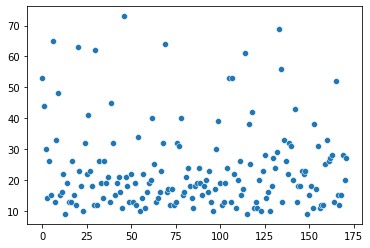

In [7]:

import seaborn as sns


eps_lengths = results_explicit.best_result["hist_stats"]["episode_lengths"]
eps = [i for i in range(len(eps_lengths))]
sns.scatterplot(eps, eps_lengths)

## Do Not Observe Velocity

In many practical

In [8]:
from ray.rllib.examples.env.stateless_cartpole import StatelessCartPole
from ray.tune import registry

registry.register_env("StatelessCartPole", lambda _: StatelessCartPole())
config["env"] = "StatelessCartPole"
# train; this takes a while
results_stateless = ray.tune.run("PPO", config=config, stop=stop)
print("Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_c29a7_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=10428) 2021-11-17 21:06:03,562	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=10428) 2021-11-17 21:06:03,562	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=10428) 2021-11-17 21:06:03,562	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-package

Trial name,status,loc
PPO_StatelessCartPole_c29a7_00000,RUNNING,127.0.0.1:10428


(pid=10428) 2021-11-17 21:06:18,385	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=10428) 2021-11-17 21:06:18,385	INFO trainable.py:110 -- Trainable.setup took 14.837 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=10428) 2021-11-17 21:06:18,387	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_StatelessCartPole_c29a7_00000,RUNNING,127.0.0.1:10428


(pid=10428) 2021-11-17 21:06:22,727	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_c29a7_00000,RUNNING,127.0.0.1:10428


Result for PPO_StatelessCartPole_c29a7_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-17_21-06-26
  done: true
  episode_len_mean: 22.71264367816092
  episode_media: {}
  episode_reward_max: 71.0
  episode_reward_mean: 22.71264367816092
  episode_reward_min: 9.0
  episodes_this_iter: 174
  episodes_total: 174
  experiment_id: 71619c5299df43d1920acafae50cf6a6
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6823717355728149
          entropy_coeff: 0.0
          kl: 0.01108759269118309
          model: {}
          policy_loss: -0.01692059449851513
          total_loss: 184.0067596435547
          vf_explained_var: 0.004661503713577986
          vf_loss: 184.02146911621094
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 40

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_c29a7_00000,TERMINATED,127.0.0.1:10428,1,8.34695,4000,22.7126,71,9,22.7126


(pid=10428) Windows fatal exception: access violation
(pid=10428) 
(pid=11920) [2021-11-17 21:06:26,945 E 11920 10592] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=11920) Windows fatal exception: access violation
(pid=11920) 
(pid=17780) [2021-11-17 21:06:26,947 E 17780 4716] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=17780) Windows fatal exception: access violation
(pid=17780) 
2021-11-17 21:06:27,057	INFO tune.py:630 -- Total run time: 37.08 seconds (36.81 seconds for the tuning loop).


Training finished successfully


In [9]:
# check results
results_stateless.default_metric = "episode_reward_mean"
results_stateless.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results_stateless.best_result["episode_reward_mean"]

22.71264367816092

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

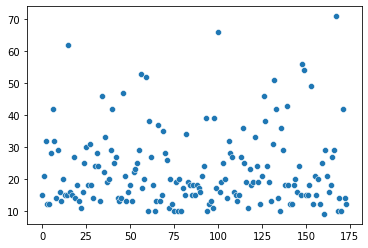

In [10]:
eps_lengths = results_stateless.best_result["hist_stats"]["episode_lengths"]
eps = [i for i in range(len(eps_lengths))]
sns.scatterplot(eps, eps_lengths)


## Stacked Observations with Attention

TODO: continue here
https://github.com/ray-project/ray/blob/master/rllib/examples/attention_net.py

In [13]:
config["model"] = {
    # Attention net wrapping (for tf) can already use the native keras
    # model versions. For torch, this will have no effect.
    "_use_default_native_models": True,
    "use_attention": True,
    "max_seq_len": 10,
    "attention_num_transformer_units": 1,
    "attention_dim": 32,
    "attention_memory_inference": 10,
    "attention_memory_training": 10,
    "attention_num_heads": 1,
    "attention_head_dim": 32,
    "attention_position_wise_mlp_dim": 32,
}

results_attention = ray.tune.run("PPO", config=config, stop=stop)
print("Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_69b1f_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_69b1f_00000,PENDING,


(pid=13208) 2021-11-17 21:10:43,262	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=13208) 2021-11-17 21:10:43,262	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=13208) 2021-11-17 21:10:43,262	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=13208) 2021-11-17 21:11:10,240	WARNING trainer_template.py:185 -- 

Trial name,status,loc
PPO_StatelessCartPole_69b1f_00000,RUNNING,127.0.0.1:13208


Trial name,status,loc
PPO_StatelessCartPole_69b1f_00000,RUNNING,127.0.0.1:13208


Trial name,status,loc
PPO_StatelessCartPole_69b1f_00000,RUNNING,127.0.0.1:13208


(pid=13208) 2021-11-17 21:11:17,383	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_69b1f_00000,RUNNING,127.0.0.1:13208


Trial name,status,loc
PPO_StatelessCartPole_69b1f_00000,RUNNING,127.0.0.1:13208


Result for PPO_StatelessCartPole_69b1f_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-17_21-11-28
  done: true
  episode_len_mean: 21.22872340425532
  episode_media: {}
  episode_reward_max: 76.0
  episode_reward_mean: 21.22872340425532
  episode_reward_min: 8.0
  episodes_this_iter: 188
  episodes_total: 188
  experiment_id: 40d12bd65db94e73a80f0dc3a2193c84
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6870076060295105
          entropy_coeff: 0.0
          kl: 0.012487230822443962
          policy_loss: -0.01982882432639599
          total_loss: 134.48117065429688
          vf_explained_var: 0.0034447365906089544
          vf_loss: 134.4984893798828
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_si

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_69b1f_00000,TERMINATED,127.0.0.1:13208,1,17.7678,4000,21.2287,76,8,21.2287


(pid=13208) [2021-11-17 21:11:28,691 E 13208 17780] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=13208) Windows fatal exception: access violation
(pid=13208) 
(pid=18984) [2021-11-17 21:11:28,714 C 18984 15404] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=18984) *** StackTrace Information ***
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyInit__raylet
(pid=18984)     PyNumber_InPlaceLshift
(pid=18984)     Py_CheckFunctionResult
(pid=18984)     PyEval_EvalFrameDefault


Training finished successfully


In [14]:
# check results
results_attention.default_metric = "episode_reward_mean"
results_attention.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results_attention.best_result["episode_reward_mean"]

21.22872340425532

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

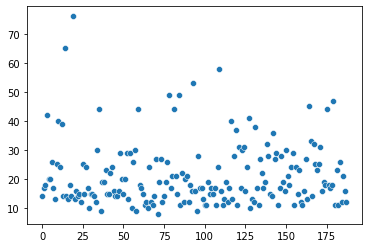

In [15]:
eps_lengths = results_attention.best_result["hist_stats"]["episode_lengths"]
eps = [i for i in range(len(eps_lengths))]
sns.scatterplot(eps, eps_lengths)

## Stateless but Stacked Frames

(maybe even with LSTM)
use `framestack = True`

